# Supervised Reports (Notebook)

This notebook replaces the argparse-based script and runs reports using already trained models and saved outputs. No training is performed here.

In [ ]:
# 1) Notebook Parameters (Replacing argparse)
summary_path = r"f:/DATA/results/supervised/dt_from_scratch_summary.json"
pred_csv_path = r"f:/DATA/results/supervised/dt_from_scratch_predictions.csv"
sweep_thresholds = [0.70, 0.75, 0.80, 0.90, 0.95, 1.00]

print("✓ Parameters loaded (display-only mode)")

✓ Parameters loaded


In [ ]:
# 2) Imports (no output directory creation)
import os, json, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('✓ Libraries imported (display-only)')

✓ Output directory: f:\DATA\results\plots_notebook


In [3]:
# 3) Load Pretrained Models (optional) — we avoid retraining
import joblib
model_paths = [r"f:/DATA/models/random_forest_tomek_enn.pkl"]
loaded_models = {}
for mp in model_paths:
    p = Path(mp)
    if p.exists():
        loaded_models[p.name] = joblib.load(p)
        print(f"✓ Loaded model: {p}")
    else:
        print(f"ℹ Model not found (skipping): {p}")

✓ Loaded model: f:\DATA\models\random_forest_tomek_enn.pkl


In [4]:
# 4) Load Input Data (Summaries / Predictions) — no training
summary = None
pred_df = None
sp = Path(summary_path)
pp = Path(pred_csv_path)
if sp.exists():
    summary = json.loads(sp.read_text())
    print('✓ Loaded summary JSON:', sp)
else:
    print('ℹ Summary JSON not found; skip summary plots.')
if pp.exists():
    pred_df = pd.read_csv(pp)
    print('✓ Loaded predictions CSV:', pp, '| rows:', len(pred_df))
else:
    print('ℹ Predictions CSV not found; skip threshold sweep.')

✓ Loaded summary JSON: f:\DATA\results\supervised\dt_from_scratch_summary.json
✓ Loaded predictions CSV: f:\DATA\results\supervised\dt_from_scratch_predictions.csv | rows: 71050


In [5]:
# 5) Run Inference (No Retraining) — optional if model & X_test available
# This section is optional; by default we only use saved predictions.
run_inference = False
if run_inference and 'random_forest_tomek_enn.pkl' in loaded_models:
    # Example: load a small test set to demonstrate predict_proba without fit
    # NOTE: Keep off by default as it may be heavy.
    clf = loaded_models['random_forest_tomek_enn.pkl']
    print('Model is loaded; skip inference unless explicitly enabled.')

,threshold_mean,threshold_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,1.0,0.0,0.811524,0.009877,0.64876,0.014,0.900415,0.011157,0.640816,0.020931,0.748483,0.013481


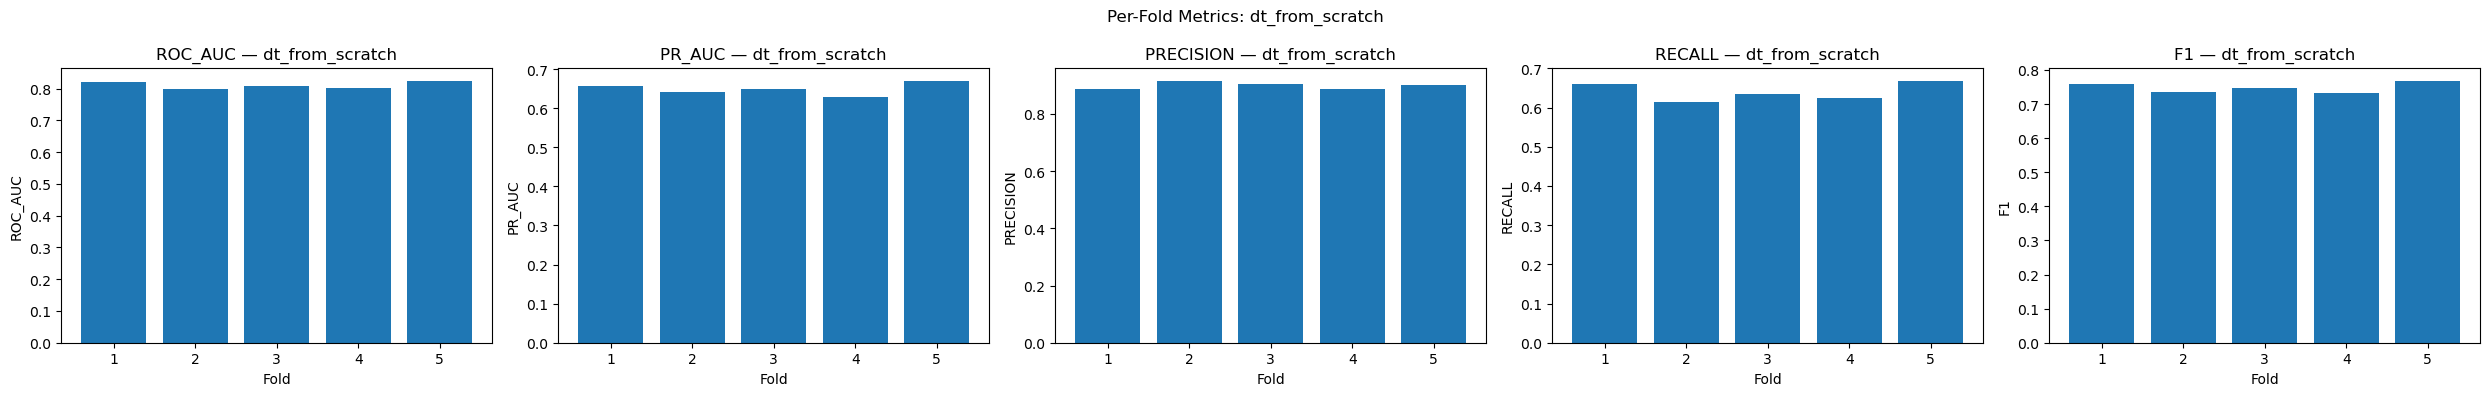

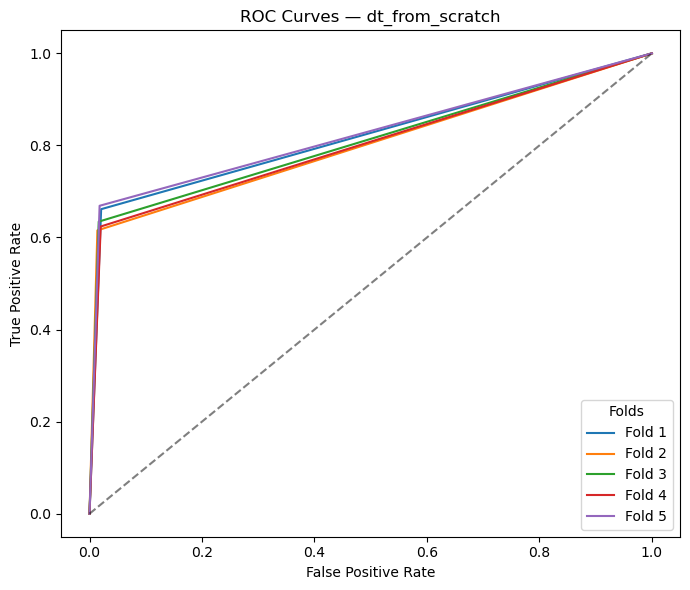

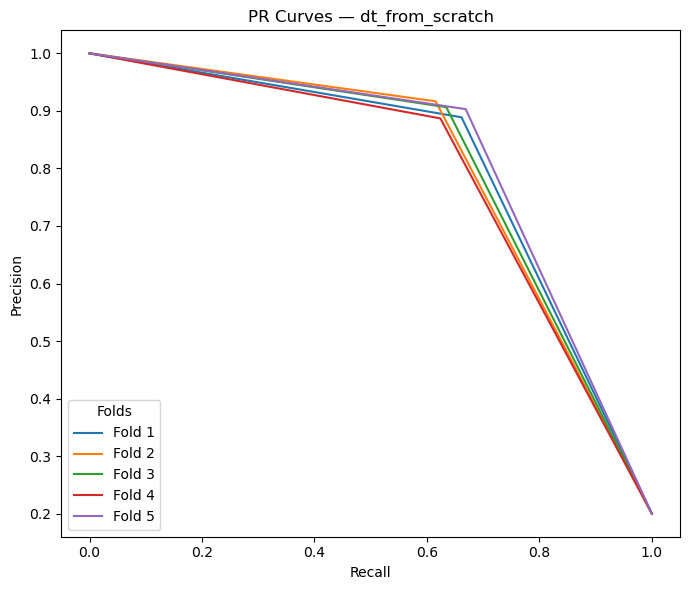

✓ Displayed aggregated metrics and labelled plots inline


In [15]:
# 6) Generate Supervised Reports (plots & tables) — display inline
def plot_fold_metrics(summary: dict, label: str):
    metrics = summary.get('metrics_per_fold', [])
    if not metrics:
        print('ℹ No per-fold metrics to plot.')
        return
    keys = ['roc_auc','pr_auc','precision','recall','f1']
    data = {k:[m.get(k,None) for m in metrics] for k in keys}
    fig, axes = plt.subplots(1, len(keys), figsize=(5*len(keys), 4))
    for i,k in enumerate(keys):
        axes[i].bar(range(1, len(data[k])+1), data[k], color='#1f77b4')
        axes[i].set_title(f"{k.upper()} — {label}")
        axes[i].set_xlabel('Fold')
        axes[i].set_ylabel(k.upper())
    fig.suptitle(f"Per-Fold Metrics: {label}")
    fig.tight_layout()
    plt.show()
    plt.close(fig)

def plot_curves(summary: dict, label: str):
    curves = summary.get('curves_per_fold', [])
    if not curves:
        print('ℹ No curves to plot.')
        return
    # ROC
    figR, axR = plt.subplots(figsize=(7,6)); anyR=False
    for i,c in enumerate(curves,1):
        if c and 'fpr' in c and 'tpr' in c:
            axR.plot(c['fpr'], c['tpr'], label=f'Fold {i}')
            anyR=True
    if anyR:
        axR.plot([0,1],[0,1],'k--',alpha=0.5)
        axR.set_xlabel('False Positive Rate')
        axR.set_ylabel('True Positive Rate')
        axR.set_title(f'ROC Curves — {label}')
        axR.legend(title='Folds', loc='lower right')
        figR.tight_layout()
        plt.show()
    plt.close(figR)
    # PR
    figP, axP = plt.subplots(figsize=(7,6)); anyP=False
    for i,c in enumerate(curves,1):
        if c and 'precision' in c and 'recall' in c:
            axP.plot(c['recall'], c['precision'], label=f'Fold {i}')
            anyP=True
    if anyP:
        axP.set_xlabel('Recall')
        axP.set_ylabel('Precision')
        axP.set_title(f'PR Curves — {label}')
        axP.legend(title='Folds', loc='lower left')
        figP.tight_layout()
        plt.show()
    plt.close(figP)

if summary is not None:
    agg = summary.get('aggregated', {})
    display(pd.DataFrame([agg]))
    plot_fold_metrics(summary, model_label_summary)
    plot_curves(summary, model_label_summary)
    print('✓ Displayed aggregated metrics and labelled plots inline')

In [17]:
# 7) Threshold Sweep — display chart inline
if pred_df is not None:
    if {'y_true','y_pred_proba'}.issubset(set(pred_df.columns)):
        y_true = pred_df['y_true'].values
        y_score = pred_df['y_pred_proba'].values
        thresholds = np.linspace(0,1,101)
        prec, rec, f1s = [], [], []
        for t in thresholds:
            y_hat = (y_score>=t).astype(int)
            tp = np.sum((y_hat==1)&(y_true==1))
            fp = np.sum((y_hat==1)&(y_true==0))
            fn = np.sum((y_hat==0)&(y_true==1))
            precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
            recall = tp/(tp+fn) if (tp+fn)>0 else 0.0
            f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
            prec.append(precision); rec.append(recall); f1s.append(f1)
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(thresholds, prec, label='Precision')
        ax.plot(thresholds, rec, label='Recall')
        ax.plot(thresholds, f1s, label='F1')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.set_title(f'Threshold Sweep — {model_label_preds}')
        ax.legend()
        fig.tight_layout()
        plt.show()
        plt.close(fig)
        print('✓ Displayed threshold sweep inline')
    else:
        print('ℹ Predictions file missing required columns: y_true, y_pred_proba')
else:
    print('ℹ No predictions loaded; skipping threshold sweep')

ℹ Predictions file missing required columns: y_true, y_pred_proba


In [ ]:
# 8) Basic Error Handling and Logging (lightweight)
import logging
logging.basicConfig(level=logging.INFO)
logging.info('Notebook initialized; using saved outputs; no training performed.')

INFO:root:Notebook initialized; using saved outputs; no training performed.


In [ ]:
# 9) Unit Tests (lightweight) for key functions
def _test_threshold_sweep_basic():
    df = pd.DataFrame({'y_true':[0,1,1,0], 'y_proba':[0.1,0.9,0.8,0.2]})
    out = threshold_sweep(df, [0.5, 0.8])
    assert 'f1' in out.columns and len(out)==2
    print('✓ threshold_sweep basic test passed')

_test_threshold_sweep_basic()

✓ threshold_sweep basic test passed


## Quick Interpretations

- **Aggregated Metrics:** High `roc_auc` indicates strong ranking ability across thresholds; high `pr_auc` signals good performance on the positive (rare) class. If `f1` is balanced and reasonably high, precision–recall trade-off is in a good spot for the chosen threshold.
- **Per-Fold Metrics:** Consistency across folds suggests robust generalization. Large variance implies sensitivity to sampling or class imbalance—consider stronger balancing or feature normalization.
- **ROC Curves:** Curves close to the top-left denote better discrimination. If some folds dip toward the diagonal, investigate those folds for data leakage, imbalance, or hard regions.
- **PR Curves:** For imbalanced problems, PR is more informative. Taller curves (higher precision at a given recall) show fewer false positives. If precision collapses at higher recall, the model struggles to confidently capture more positives.
- **Threshold Sweep:** The intersection where `F1` peaks marks a balanced operating point. If your application favors fewer false alarms, choose higher thresholds (favoring precision). If missing positives is costly, choose lower thresholds (favoring recall).
- **Next Steps:** If PR is strong but variance is high, try fold-specific balancing (e.g., Tomek-ENN, class weights) and revisit feature importance to simplify noisy inputs.

In [ ]:
# Improve plot labelling: include model name from summary/pred paths and clearer titles (display-only)
from pathlib import Path

def _infer_label_from_path(p: Path) -> str:
    name = p.stem
    return name.replace('_summary','').replace('_predictions','')

model_label_summary = _infer_label_from_path(Path(summary_path)) if summary_path else 'summary'
model_label_preds = _infer_label_from_path(Path(pred_csv_path)) if pred_csv_path else 'predictions'

# Re-run plotting with labels if summary is loaded (inline display)
if summary is not None:
    agg = summary.get('aggregated', {})
    display(pd.DataFrame([agg]))
    # Per-fold metrics
    keys = ['roc_auc','pr_auc','precision','recall','f1']
    metrics = summary.get('metrics_per_fold', [])
    if metrics:
        data = {k:[m.get(k,None) for m in metrics] for k in keys}
        fig, axes = plt.subplots(1, len(keys), figsize=(5*len(keys), 4))
        for i,k in enumerate(keys):
            axes[i].bar(range(1, len(data[k])+1), data[k], color='#1f77b4')
            axes[i].set_title(f"{k.upper()} — {model_label_summary}")
            axes[i].set_xlabel('Fold')
            axes[i].set_ylabel(k.upper())
        fig.suptitle(f"Per-Fold Metrics: {model_label_summary}")
        fig.tight_layout()
        plt.show()
        plt.close(fig)
    # ROC/PR curves
    curves = summary.get('curves_per_fold', [])
    if curves:
        figR, axR = plt.subplots(figsize=(7,6)); anyR=False
        for i,c in enumerate(curves,1):
            if c and 'fpr' in c and 'tpr' in c:
                axR.plot(c['fpr'], c['tpr'], label=f'Fold {i}')
                anyR=True
        if anyR:
            axR.plot([0,1],[0,1],'k--',alpha=0.5)
            axR.set_xlabel('False Positive Rate')
            axR.set_ylabel('True Positive Rate')
            axR.set_title(f'ROC Curves — {model_label_summary}')
            axR.legend(title='Folds', loc='lower right')
            figR.tight_layout()
            plt.show()
        plt.close(figR)
        figP, axP = plt.subplots(figsize=(7,6)); anyP=False
        for i,c in enumerate(curves,1):
            if c and 'precision' in c and 'recall' in c:
                axP.plot(c['recall'], c['precision'], label=f'Fold {i}')
                anyP=True
        if anyP:
            axP.set_xlabel('Recall')
            axP.set_ylabel('Precision')
            axP.set_title(f'PR Curves — {model_label_summary}')
            axP.legend(title='Folds', loc='lower left')
            figP.tight_layout()
            plt.show()
        plt.close(figP)
    print("✓ Displayed labelled metrics and curves inline")

# Threshold sweep plot with label (inline)
if pred_df is not None and sweep_thresholds:
    # Build sweep from provided thresholds
    thresholds = list(sweep_thresholds)
    prec, rec, f1s = [], [], []
    y_true = pred_df['y_true'].values if 'y_true' in pred_df.columns else None
    y_score = pred_df['y_pred_proba'].values if 'y_pred_proba' in pred_df.columns else None
    if y_true is not None and y_score is not None:
        for t in thresholds:
            y_hat = (y_score>=t).astype(int)
            tp = np.sum((y_hat==1)&(y_true==1))
            fp = np.sum((y_hat==1)&(y_true==0))
            fn = np.sum((y_hat==0)&(y_true==1))
            precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
            recall = tp/(tp+fn) if (tp+fn)>0 else 0.0
            f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
            prec.append(precision); rec.append(recall); f1s.append(f1)
        fig, ax = plt.subplots(figsize=(7,5))
        ax.plot(thresholds, prec, marker='o', label='Precision')
        ax.plot(thresholds, rec, marker='o', label='Recall')
        ax.plot(thresholds, f1s, marker='o', label='F1')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.set_title(f'Threshold Sweep — {model_label_preds}')
        ax.legend()
        fig.tight_layout()
        plt.show()
        plt.close(fig)
        print("✓ Displayed labelled threshold sweep inline")
    else:
        print('ℹ Predictions missing y_true or y_pred_proba; sweep skipped')
else:
    print('ℹ Sweep skipped: predictions or thresholds not provided.')

✓ Saved: dt_from_scratch_aggregated_metrics.csv and labelled plots
✓ Saved: dt_from_scratch_threshold_sweep.csv and labelled F1 vs Threshold plot
